In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("..")

from diabetes_prediction.utils.data.dataloader import *
from diabetes_prediction.utils.data.metrics import *
from diabetes_prediction.utils.data.feature_selection import *

# 1. Generate Dataset

In [2]:
data_ids = ['family', 'sample_adult', 'sample_child']

metadatas, datas = {}, {}
for data_id in data_ids:
    metadatas[data_id], datas[data_id] = load_dataset(data_id)

* load_metadata                | 0.02s (0.00m)
* load_dataset                 | 0.20s (0.00m)
* load_metadata                | 0.02s (0.00m)
* load_dataset                 | 0.85s (0.01m)
* load_metadata                | 0.02s (0.00m)
* load_dataset                 | 0.08s (0.00m)


In [3]:
metadata, data = load_merged_datas(metadatas, datas)

* load_merged_datas            | 0.70s (0.01m)


# 2. Preprocessing

In [4]:
dataset = split_data(data, drop_unknown=True)

Remove records with unknown label (762 records from 25417 records).
* split_data                   | 0.14s (0.00m)


In [5]:
dataset_proc = load_processed_dataset(metadata, dataset)

* load_processed_dataset       | 0.36s (0.01m)


In [6]:
train_data = dataset_proc['train']

# 3. Feature Selection

## 3.1 Numerical Features

### 3.1.1 Correlation Coefficients

#### 3.1.1.1 Correlation between Features vs Target
Select features with cumulative sum of `|corr(X, y)|` threshold.

In [ ]:
selector = CorrelationYFeatureSelector(metadata, train_data)

In [ ]:
selector.select(0.3)

#### 3.1.1.2 Correlation between Features
Drop highly correlated features.

In [ ]:
fs = CorrelationXFeatureSelector(metadata, train_data)

In [ ]:
fs.select(0.8)

### 3.1.2 Multicollinearity
#### 1) VIF
1. Detect multicollinearity using **Variance Inflation Factor (VIF)** \
VIF: Measure the strength of correlation between predictor variables
2. Interprete VIF
    - `VIF = 1` : **No correlation** between predictor variable and any other predictor variables.
    - `1 < VIF ≤ 5` : **Moderate correlation** ~.
    - `5 < VIF` : **Severe correlation** ~
    
#### 2) Correlation Coefficients
1. Select biggest 

In [147]:
fs = CorrelationXYFeatureSelector(metadata, train_data)

* get_corr                     | 2.05s (0.03m)


In [162]:
selected_features = fs.select(0.5)

[########################################] | 100% Completed | 114.13 s
* get_VIF                      | 114.92s (1.92m)


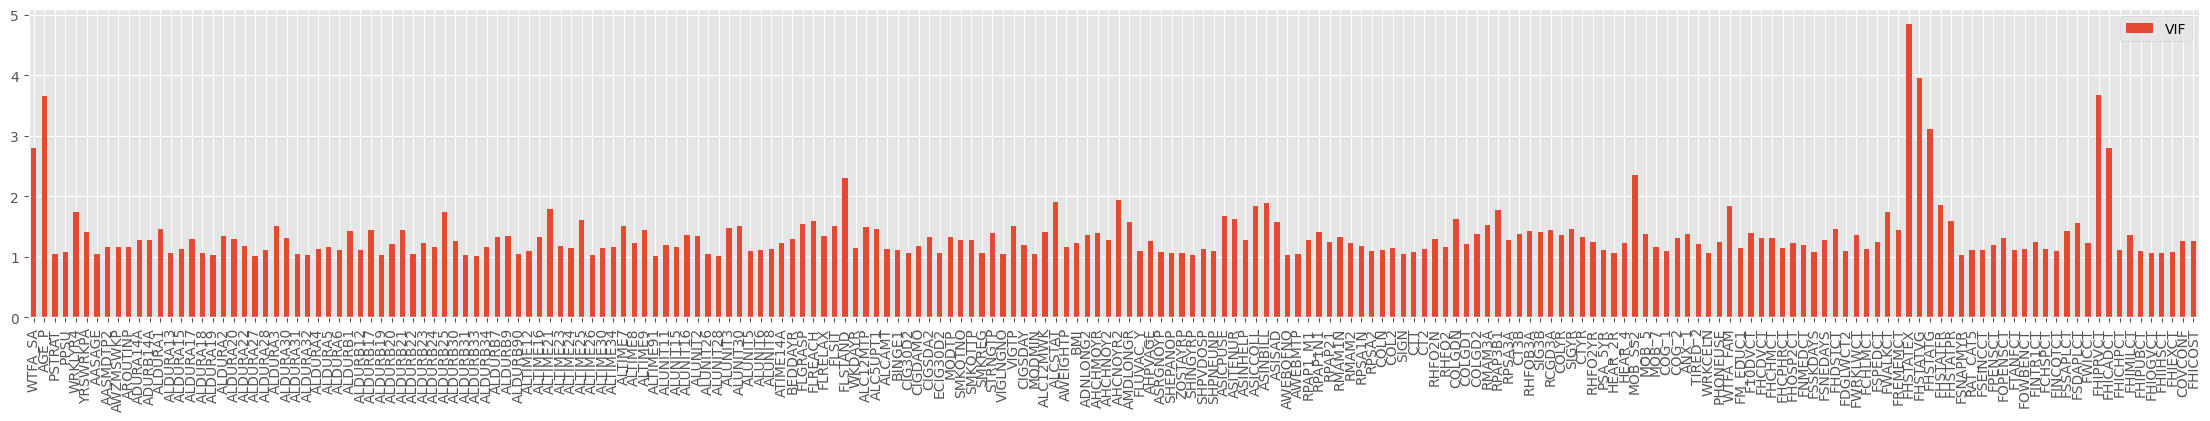

In [159]:
vif_data = get_VIF(train_data[selected_features], plot=True)

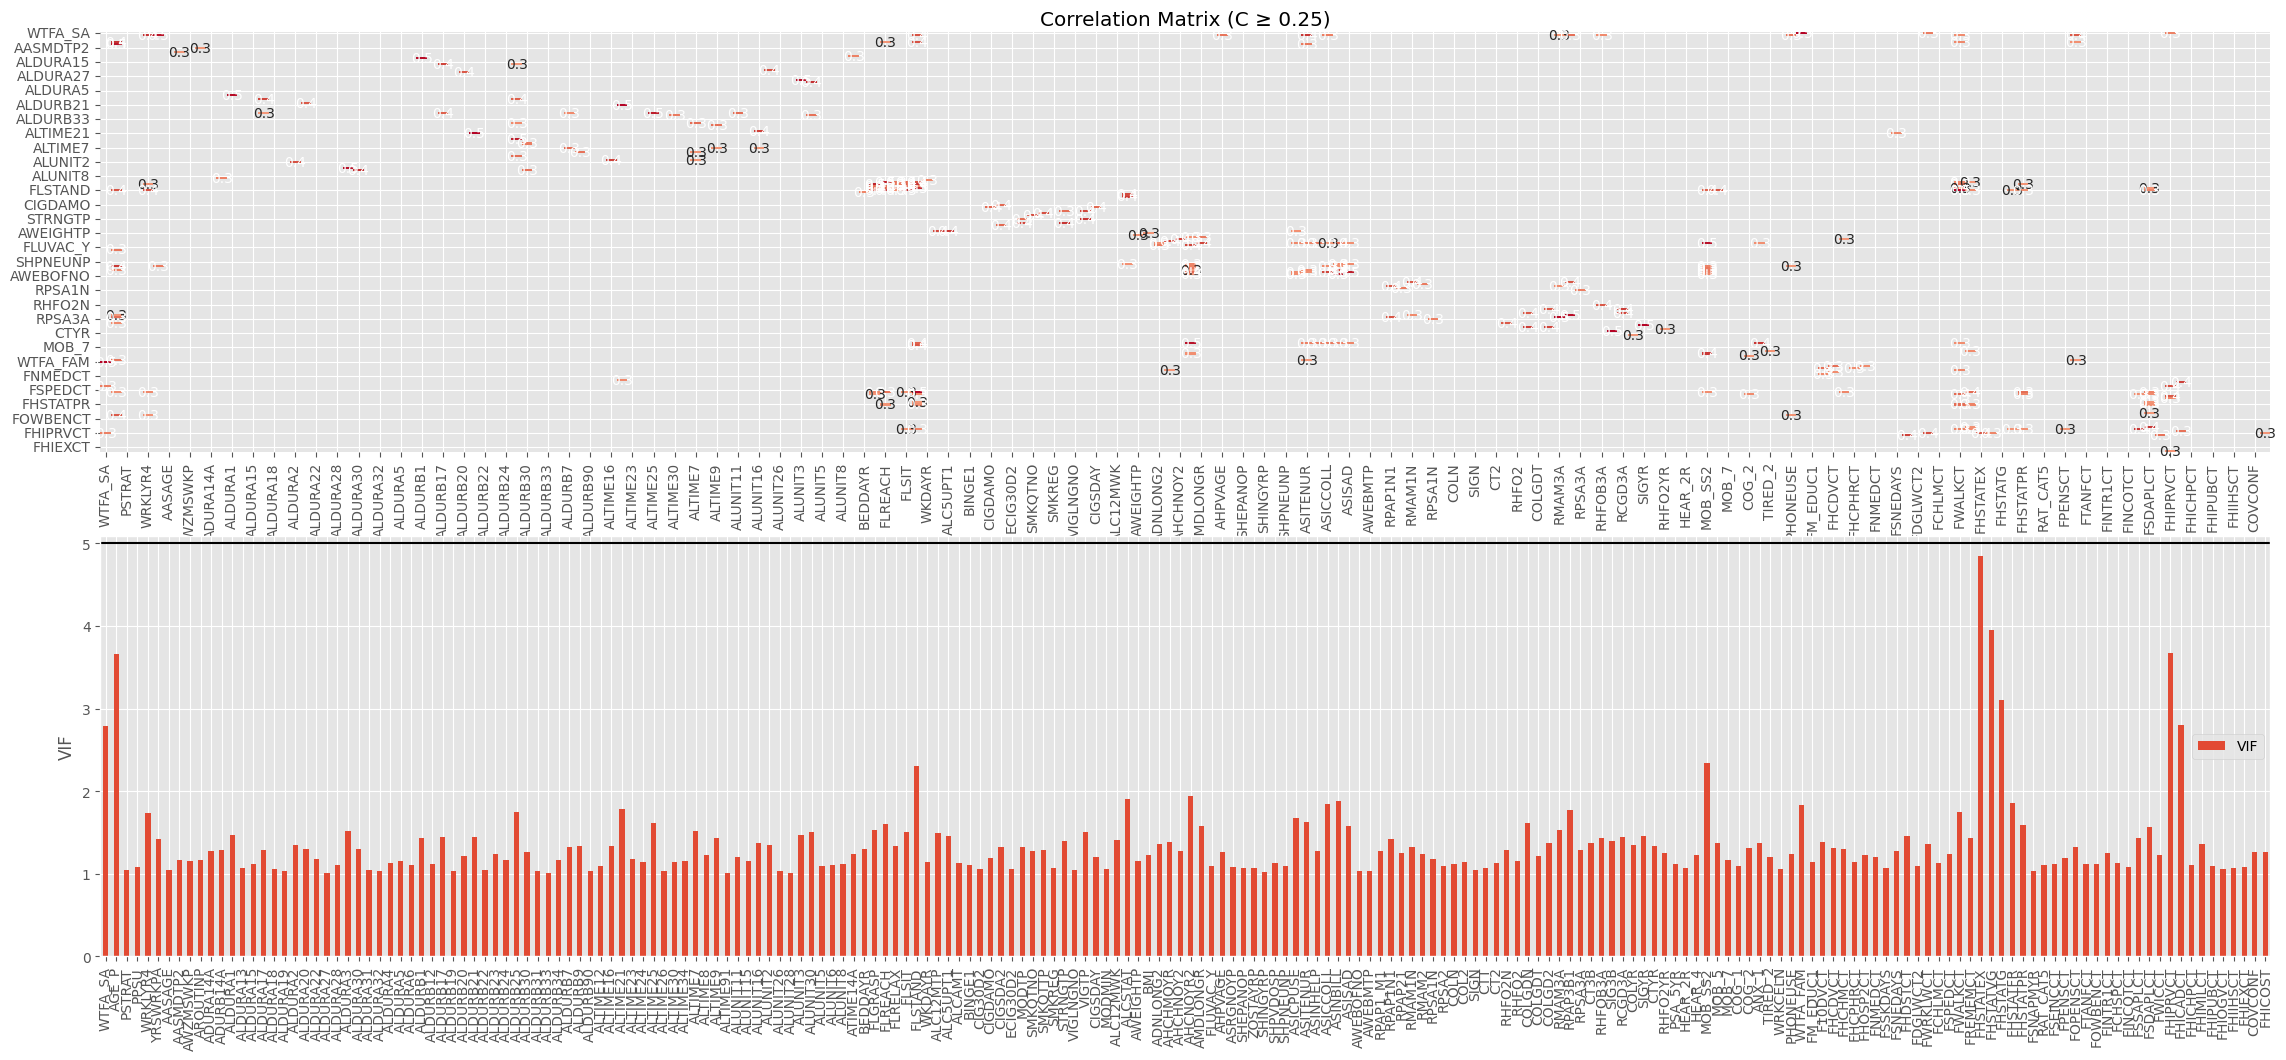

In [198]:
plot_correlations(train_data, vif_data, selected_features)

In [199]:
merge_features_metadata(selected_features, metadata)

NameError: name 'merge_features_metadata' is not defined